# Segment Anything 官方推理

# 一、环境准备

## 1.检查 CUDA 状态

多卡需禁用，或者运行后重启内核。

In [29]:
import torch

def check_cuda():
    flag = torch.cuda.is_available()
    if flag:
        print("CUDA可使用")
    else:
        print("CUDA不可用")

    # 获取GPU数量
    ngpu = torch.cuda.device_count()
    print("GPU数量：",ngpu)
    # Decide which device we want to run on
    device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    print("驱动为：",device)
    print("GPU型号： ",torch.cuda.get_device_name(0))


check_cuda()

CUDA可使用
GPU数量： 2
驱动为： cuda:1
GPU型号：  NVIDIA GeForce RTX 3090


## 2.可视化方法

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

def trans_ori_comparision(
        id, image, mask, ori_dataset,
        point=None, bbox=None, cls_labels=None,
        mean=None, std=None, max_show_num=1,
    ):
    assert image is not None and mask is not None and id is not None, "image, label, id 不可缺少"
    assert max_show_num <= id.shape[0], "展示长度大于图片集长度"

    # tensor -> numpy
    id = id.detach().cpu().numpy()
    imgs_arr = image.detach().cpu().permute(1, 2, 0).numpy()
    masks_arr = mask.detach().cpu().permute(1, 2, 0).numpy()
    masks_arr = masks_arr > 0

    if point is not None or bbox is not None:

        cls_labels_arr = cls_labels.detach().cpu().numpy()
    
        if point is not None:
            points_arr = point.detach().cpu().numpy()
        
        if bbox is not None:
            bboxs_arr = bbox.detach().cpu().numpy().squeeze()

    if mean is not None and std is not None:
        imgs_arr = imgs_arr * std + mean

    for i in range(max_show_num):
        id = id[i]
        img_arr = imgs_arr[i]
        mask_arr = masks_arr[i]

        # 创建一个包含两个子图的图形
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))

        # 显示第一个图像
        axs[0].imshow(img_arr)
        axs[0].axis('on')
        show_mask(mask_arr, axs[0])

        # 显示第二个图像
        img_ori, mask_ori, prompt = ori_dataset.get(id)
        img_ori = np.array(img_ori)
        mask_ori = np.array(mask_ori) > 0
        point_ori = prompt.get('point', None)
        bbox_ori = prompt.get('bbox', None)

        axs[1].imshow(img_ori)
        axs[1].axis('on')
        show_mask(mask_ori, axs[1])
        
        # 统一画线
        if point is not None or bbox is not None:
            cls_label_arr = cls_labels_arr[i]
            if point is not None:
                point_arr = points_arr[i]
                show_points(point_arr, cls_label_arr, axs[0])
                show_points(point_ori, cls_label_arr, axs[1])

            if bbox is not None:
                bbox_arr = bboxs_arr[i]
                show_box(bbox_arr, axs[0])
                show_box(bbox_ori.squeeze(), axs[1])

        # 显示图形
        plt.show()

# 二、推理

## 1.定义模型

In [31]:
from segment_anything import sam_model_registry


sam = sam_model_registry["vit_b"](checkpoint="../checkpoints/sam/sam_vit_b_01ec64.pth")

## 2.定义数据

In [32]:
import numpy as np
from PIL import Image, ImageDraw

img_path = '/home/zijieshen/new_disk/datasets/ISIC2016/P1/Train/Images/ISIC_0000000.jpg'
mask_path = img_path.replace(
    'Images', 'Masks'
).replace(
    '.jpg', '_Segmentation.png'
)

img = Image.open(img_path).convert('RGB')
mask = Image.open(mask_path).convert('L')

img_arr = np.array(img)
mask_arr = np.array(mask)

数据可视化

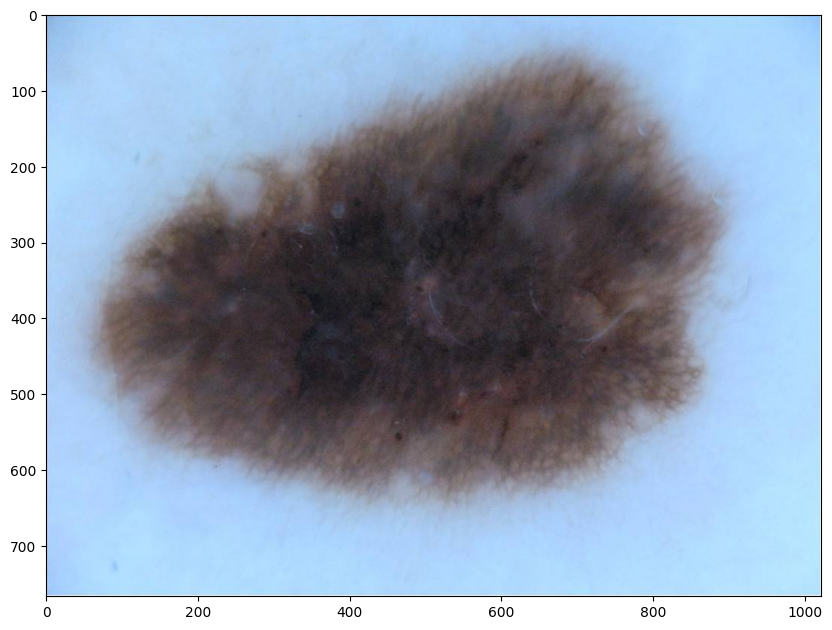

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(img_arr)
plt.axis('on')
plt.show()

## 3.定义 prompt

是否随机

In [34]:
use_random = False

选框

In [35]:
import random

coords = np.argwhere(mask_arr > 0)
y1, x1 = coords.min(axis=0)
y2, x2 = coords.max(axis=0)

if use_random:
    sign = random.choice([-1, 1])
    x1 += sign * random.randint(0, int(0.1 * (x2 - x1)))
    x1 = max(0, x1)
    sign = random.choice([-1, 1])
    x2 += sign * random.randint(0, int(0.1 * (x2 - x1)))
    x2 = min(mask_arr.shape[1], x2)
    sign = random.choice([-1, 1])
    y1 += sign * random.randint(0, int(0.1 * (y2 - y1)))
    y1 = max(0, y1)
    sign = random.choice([-1, 1])
    y2 += sign * random.randint(0, int(0.1 * (y2 - y1)))
    y2 = min(mask_arr.shape[0], y2)

bbox = np.array([
    x1, y1, x2, y2
])

选点

In [36]:
if use_random:
    point = np.array([
        tuple(random.choice(coords))
    ])
else:
    point = np.array([
        tuple(coords.mean(axis=0))
    ])

point = point[:, ::-1]
point_label = np.array([1])

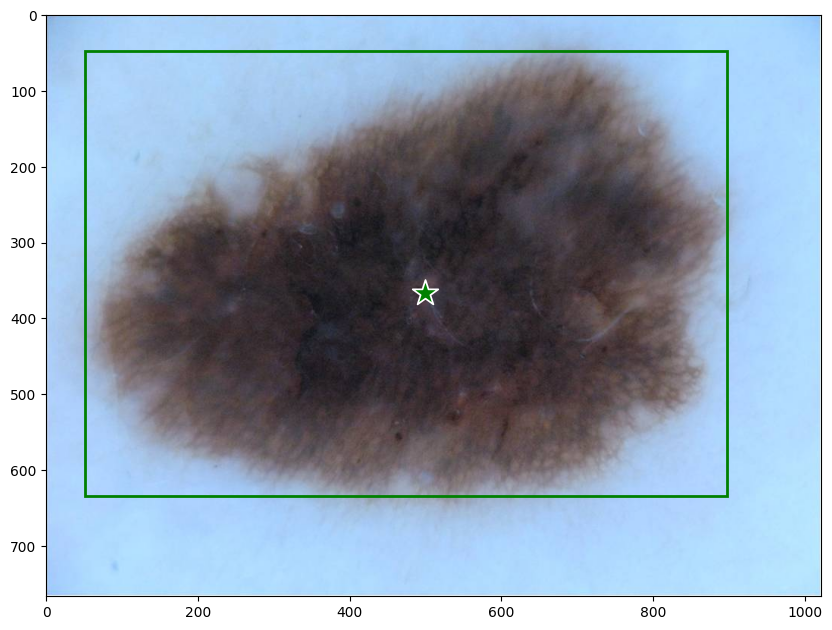

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(img_arr)
show_points(point, point_label, plt.gca())
show_box(bbox, plt.gca())
plt.axis('on')
plt.show()

## 4.推理

In [38]:
from segment_anything import SamPredictor

predictor = SamPredictor(sam)
predictor.set_image(img_arr)

### 1.点推理

In [39]:
masks, scores, low_res_masks = predictor.predict(
    point_coords=point,
    point_labels=point_label,
    multimask_output=False
)

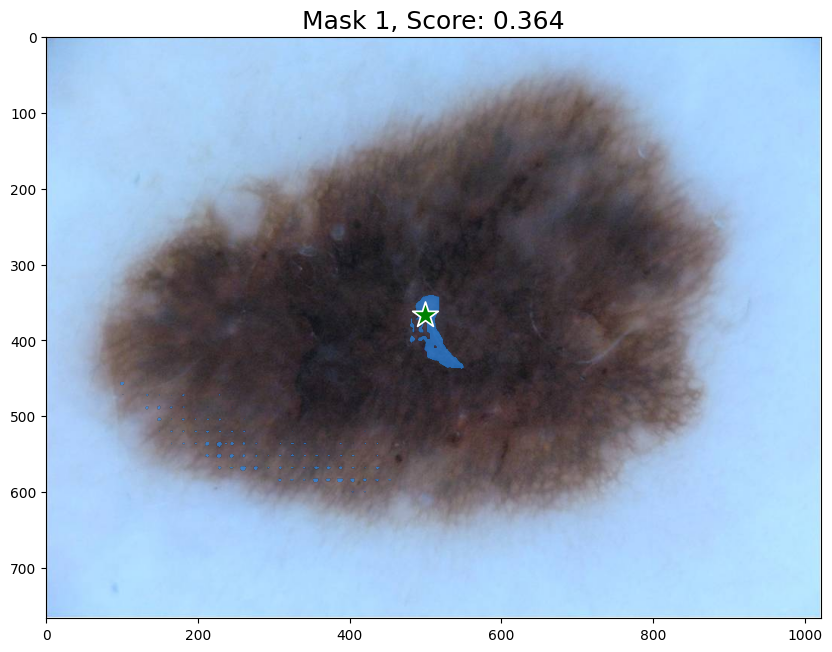

In [40]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(img_arr)
    show_mask(mask, plt.gca())
    show_points(point, point_label, plt.gca())
    plt.title(f"Mask {i + 1}, Score: {score:.3f}", fontsize=18)
    plt.axis('on')
    plt.show()

### 2.框推理

In [41]:
masks, _, _ = predictor.predict(
    box=bbox[None, :],
    multimask_output=False
)

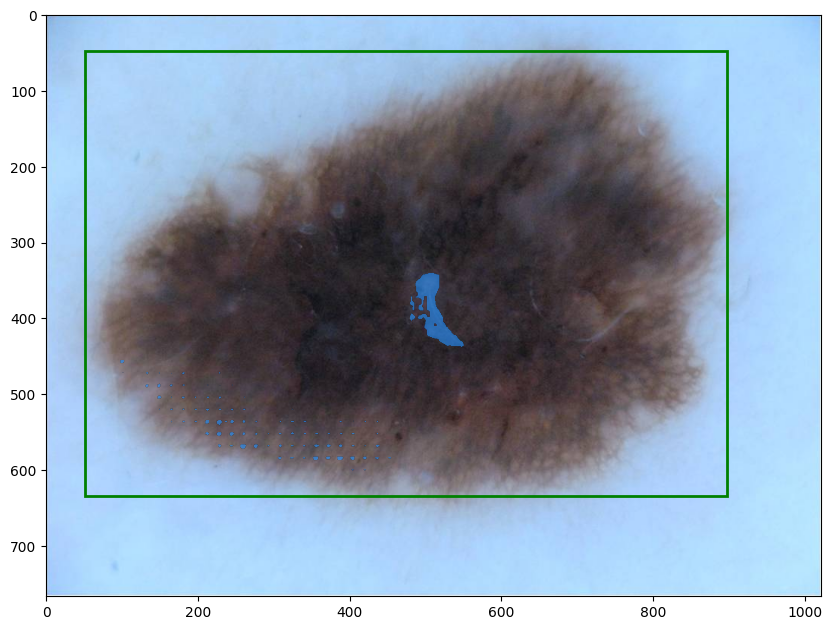

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(img_arr)
show_mask(mask, plt.gca())
show_box(bbox, plt.gca())
plt.axis('on')
plt.show()